# Random Forest Classifier

We begin our analysis with randomm forest classifer. Random forest is the meta estimator which fits number of decision tree classifiers on various subsamples of data and uses averaging for improving the model accuracy.  

In [275]:
# Load required packages
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import GridSearch, EqualizedOdds
import shap
import plotly.express as px
import matplotlib.pyplot as plt

## Modelling Company Employees

In [2]:
# Load data into dataframe
df = pd.read_csv('./../../../datasets/preprocessed_ce.csv')

### Splitting data

In [3]:
tgt_col = 'have you ever sought treatment for a mental health disorder from a mental health professional?'
y = df[tgt_col]
X = df.drop(tgt_col, axis=1)

Let's check if the data is imbalanced or not.

In [4]:
# Split data into trainining and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [5]:
# Keep copy of original variables
X_train_ori = X_train.copy()
X_test_ori = X_test.copy()

### Categorical features encoding

Before we move forward to encode categorical features, it is necessary to identify them first.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 55 columns):
 #   Column                                                                                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                          --------------  -----  
 0   are you self-employed?                                                                                                                                                                                                          1225 non-null   int64  
 1   how many employees does your company or organization have?                                                                       

Looking at the information of dataframe, there are quite a lot of fetuares which has data type as "object". It is not necessary that all the features with data type as "object" be categorical features. There may be certain columns which might binary values which can be represented by booleans. It is better to check column one by one.  
But for now, I would like to go with the assumption that all the columns with data type as "object" are categorical columns.

In [24]:
cat_cols = df.select_dtypes(include=['object']).columns

There are 32 columns out of 55 which are categorical in nature. Out of those, after examining the data manually, we can infer that one of them is ordinal in nature and others can be treated as nominal columns. The column - "how many employees does your company or organization have?" - which gives information regarding the size of the company can be treated as ordinal coulmn.

In [8]:
# Encoding ordinal column for training data
X_train['how many employees does your company or organization have?'] = X_train['how many employees does your company or organization have?'].replace({'1-5':1, 
                                                                                                                                              '6-25':2, 
                                                                                                                                              '26-100':3, 
                                                                                                                                              '100-500':4,
                                                                                                                                              '500-1000':5,
                                                                                                                                              'More than 1000':6})

# Encoding ordinal column for testing data
X_test['how many employees does your company or organization have?'] = X_test['how many employees does your company or organization have?'].replace({'1-5':1, 
                                                                                                                                              '6-25':2, 
                                                                                                                                              '26-100':3, 
                                                                                                                                              '100-500':4,
                                                                                                                                              '500-1000':5,
                                                                                                                                              'More than 1000':6})

<ipython-input-8-d59b31438a42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['how many employees does your company or organization have?'] = X_train['how many employees does your company or organization have?'].replace({'1-5':1,
<ipython-input-8-d59b31438a42>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['how many employees does your company or organization have?'] = X_test['how many employees does your company or organization have?'].replace({'1-5':1,


In [9]:
# Encoding nominal columns for training data
for column in cat_cols:
    dummy = pd.get_dummies(X_train[column], prefix=str(column))
    X_train = pd.concat([X_train, dummy], axis=1)
    X_train.drop(column, axis=1, inplace=True)
    
# Encoding nominal columns for testing data
for column in cat_cols:
    dummy = pd.get_dummies(X_test[column], prefix=str(column))
    X_test = pd.concat([X_test, dummy], axis=1)
    X_test.drop(column, axis=1, inplace=True)

In [10]:
# Fill value 0 for mismatched columns
mis_cols = list(set(X_train.columns) - set(X_test.columns))
X_test[mis_cols] = 0

### Imbalance check

In [11]:
y.value_counts()

1    779
0    446
Name: have you ever sought treatment for a mental health disorder from a mental health professional?, dtype: int64

The data is imbalanced. In order to use any of the machine learning algorithm, we need to either over the minority class or downsample the majority. Considering the fact that we have less number of records in the data set, it is better to oversample. But, only training data needs to be oversample.  
For oversampling, Sample Minority Oversampling Technique (SMOTE) will be used.

In [13]:
# Oversample the minority class in the target variable
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train.values, y_train.ravel())

### Model training

There are various paramters which random forest algorithm uses to train the model. Our aim is to find those paramters, also known as hyperparamters, which yeilds us the model with the best fit.

In [14]:
# Declare parameters for grid search

# Declare the classifer
clf = RandomForestClassifier(class_weight="balanced", bootstrap=True, oob_score=True)

# Declare the paramter grid for searching
param_grid = dict(
    n_estimators = [100, 200, 400],
    criterion = ['gini', 'entropy'],
    max_depth = [10, 20, 40, None],
    max_features = ['sqrt', 'log2', None],
    max_samples = [0.4, 0.8, None]
)

In [15]:
# Train the model
rf_clf = GridSearchCV(clf, param_grid, scoring='f1', n_jobs=7, cv=5, verbose=2)
rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              oob_score=True),
             n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 40, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.4, 0.8, None],
                         'n_estimators': [100, 200, 400]},
             scoring='f1', verbose=2)

In [16]:
rf_clf.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='sqrt', max_samples=0.8,
                       oob_score=True)

In [44]:
# Save and load the model if required
import joblib
# joblib.dump(rf_clf.best_estimator_, './../../../models/rf_clf.pkl')
rf_clf = joblib.load('./../../../models/rf_clf.pkl')

In [45]:
# Predict outcomes with test set
# y_pred = rf_clf.best_estimator_.predict(X_test)
y_pred = rf_clf.predict(X_test)

### Model Evaluation

In order to compute sensitivity and specificity, we need values such as true positives, true negatives, false positives and false neagatives. These values can be easily obtained from confusion matrix.

In [46]:
# Get values from confusion metrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [50]:
# Compute sensitivity
sensitivity = tp/(tp+fn)
print(f"Sensitivity: {sensitivity} \n")
# Compute specificity
specificity = tn/(tn+fp)
print(f"Specificity: {specificity} \n")
# Compute f1 score 
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1} \n")

# Compute classicfication report
print(classification_report(y_test, y_pred))

Sensitivity: 0.8662420382165605 

Specificity: 0.8068181818181818 

F1 score: 0.8774193548387097 

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        88
           1       0.89      0.87      0.88       157

    accuracy                           0.84       245
   macro avg       0.83      0.84      0.83       245
weighted avg       0.85      0.84      0.85       245



From the above report, it can inferred that model is finding it difficult to predict people who need to seek help from mental health professional and that can be acceptable. It won't harm any of us to visit a mental health professional even if we need not seek any help for any mental health issue. On the other hand the model is quite good at telling in case we that much needed help from mental health professional. An average F1 score of 0.83 and the overall F1 score of 0.88 is quite good considering the amount of data that we are training with. Though the model is quite better in predicting the individuals who need help than the ones who do not, the values of specificity and sensitivity are not far apart and hence the overall performance of the model is laudable.

### Fairness evaluation

There are certain sensitive columns present in the data for which model should be less likely to be biased. Following are the columns for which we will be expecting that model be fair as much as possible:
1. Feature revealing gender of the participant ('what is your gender?')
2. Feature revealing race of the participant ('what is your race?')

#### Disparity check with respect to gender

In [66]:
# Create fairness metrics with respect to gender
fair_metrics_sex = MetricFrame({'f1': f1_score, 'precision': precision_score, 'recall': recall_score},
                          y_test, y_pred, sensitive_features=X_test_ori['what is your gender?'])

In [67]:
# Display overall metrics
fair_metrics_sex.overall

f1           0.877419
precision    0.888889
recall       0.866242
dtype: object

The overall metrics remains the same as the ungrouped metrics metrics that are calculated above. The overall precision and recall are close enough, indicating that the most of the people selected by the model for seeking help for mental health issues are relevant and also the most of the relevant people are picked by the model. Though obviously, there is huge scope for model improvement.

In [68]:
# Display metrcis by group
fair_metrics_sex.by_group

,f1,precision,recall
what is your gender?,,,
female,0.900901,0.925926,0.877193
male,0.864865,0.869565,0.860215
other,0.857143,0.857143,0.857143


Model is finding it easier to tag more female candidates who need help than the other counterparts.

In [69]:
diff_metrics = pd.DataFrame(fair_metrics_sex.difference(method='between_groups'), columns=['Difference'])
diff_metrics['Percentage'] = diff_metrics['Difference']*100
diff_metrics

,Difference,Percentage
f1,0.043758,4.375804
precision,0.068783,6.878307
recall,0.02005,2.005013


On a positive note, the difference between the minimum and the maximum metric is not huge

#### Disparity check with respect to race

In [70]:
# Create fairness metrics
fair_metrics_race = MetricFrame({'f1': f1_score, 'precision': precision_score, 'recall': recall_score},
                          y_test, y_pred, sensitive_features=X_test_ori['what is your race?'])

In [71]:
# Display overall metrics
fair_metrics_race.overall

f1           0.877419
precision    0.888889
recall       0.866242
dtype: object

In [72]:
# Display metrcis by group
fair_metrics_race.by_group

,f1,precision,recall
what is your race?,,,
Asian,0.666667,0.666667,0.666667
Black or African American,1.0,1.0,1.0
I prefer not to answer,0.764706,0.764706,0.764706
More than one of the above,0.8,1.0,0.666667
White,0.917031,0.929204,0.905172


The model is working perfectly for black or African Americans but working the worst for asian participants. Moreover, for people belongs to more than one race, people selected by the model for help are all relevant but it could not identify all the those who are relevant. For white participants, model is working quite good and the disparity differences with the highest expected value is quite less.

In [73]:
diff_metrics = pd.DataFrame(fair_metrics_race.difference(method='between_groups'), columns=['Difference'])
diff_metrics['Percentage'] = diff_metrics['Difference']*100
diff_metrics

,Difference,Percentage
f1,0.333333,33.333333
precision,0.333333,33.333333
recall,0.333333,33.333333


The disparity between the scores are huge and it should be mitigated.

### Mitigated Model Training

Here we will be utilizing the best estimator that we trained using grid search. For the constraint, we will be utilizing the equalized odds method.

**Equalized Odds Parity**  
This parity is considered for binary classification. Let $X$ denote the feature vector, $A$ denote a senstive feature, $Y$ be the true labels. Parity constraint defined over the distribution of $(X, A, Y)$ is that a classifier $h$ satisfies equalized odds unders a distribution over $(X, A, Y)$ if its prediction $h(X)$ is conditionally independent of the sensitive feature $A$ given the true label $Y$. Mathematically, it can be expressed as - 
$ E[h(x) | A=a, Y=y] = E[h(X) | Y=y]$

In [243]:
# Declare paramters for mitigated model training
best_estimator = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                                        max_depth=10, max_features='sqrt', 
                                        max_samples=0.8,oob_score=True, bootstrap=True)

# Declare the constraint for training
constraint = EqualizedOdds(difference_bound=0.01)

# Select sensitive features
X_train_rc = pd.DataFrame(X_train, columns=X_test.columns)
sensitive_features_columns = [column for index, column in enumerate(X_test.columns) if ('what is your gender?' in column) or ('what is your race?' in column)]

In [244]:
# Re-arrange the training data 
X_train_sf = X_train_rc[sensitive_features_columns]
X_train_rc.drop(sensitive_features, axis=1, inplace=True)

In [245]:
# Train the model
mitigator = GridSearch(best_estimator, constraint, grid_size=100)

In [ ]:
mitigator.fit(X_train_rc, y_train, sensitive_features=X_train_sf)

In [247]:
# Save and load the model if required
# import joblib
# joblib.dump(mitigator, './../../../models/mitigated_rf_clf.pkl')
# mitigated_rf = joblib.load('./../../../models/mitigated_rf_clf.pkl')

In [248]:
# Apply the transformations to the testing data
X_test_rc = X_test.drop(sensitive_features, axis=1)

In [249]:
# Predict using the mitigated models
y_pred_mitigated = mitigator.predict(X_test_rc)

### Mitigated Model Evaluation

For mitigated models, the metrics for evaluation remains the same that are sensitivity, specificity, f1 score, precision and recall.

In [250]:
# Get values from confusion metrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mitigated).ravel()

In [251]:
# Compute sensitivity
sensitivity = tp/(tp+fn)
print(f"Sensitivity: {sensitivity} \n")
# Compute specificity
specificity = tn/(tn+fp)
print(f"Specificity: {specificity} \n")
# Compute f1 score 
f1 = f1_score(y_test, y_pred)
print(f"F1 score: {f1} \n")

# Compute classicfication report
print(classification_report(y_test, y_pred_mitigated))

Sensitivity: 0.8598726114649682 

Specificity: 0.7727272727272727 

F1 score: 0.8774193548387097 

              precision    recall  f1-score   support

           0       0.76      0.77      0.76        88
           1       0.87      0.86      0.87       157

    accuracy                           0.83       245
   macro avg       0.81      0.82      0.81       245
weighted avg       0.83      0.83      0.83       245



For mitigated models, there is no huge difference in the evaluations metrics as compared to the unmitigated models. The average f1 score decrease by just 0.02 but the overall f1 did not take a major hit. The difference between sensitivity and specificity has increased significantly.  
It is necessary to achieve the balance between performance and fairness. Moreover, there is no major hit on the performance of the model.

### Fairness Evaluation for Mitigated Models

Here again, we will be evaluating the model with respect to the selected sensitive features which are related to gender and race of the participants.

In [252]:
# Create fairness metrics with respect to gender
fair_metrics_sex = MetricFrame({'f1': f1_score, 'precision': precision_score, 'recall': recall_score},
                          y_test, y_pred_mitigated, sensitive_features=X_test_ori['what is your gender?'])

In [253]:
# Display overall metrics
fair_metrics_sex.overall

f1           0.865385
precision    0.870968
recall       0.859873
dtype: object

The recall has decreased by just 0.01 which is not at all huge as compared to the increase the fairness of the model.

In [254]:
# Display metrcis by group
fair_metrics_sex.by_group

,f1,precision,recall
what is your gender?,,,
female,0.875,0.890909,0.859649
male,0.860215,0.860215,0.860215
other,0.857143,0.857143,0.857143


The models is struggling with respect to the participants other than binary but the difference in parity has decreased.

```{margin}
Research in progress for decreasing the parity.
```

In [255]:
diff_metrics = pd.DataFrame(fair_metrics_sex.difference(method='between_groups'), columns=['Difference'])
diff_metrics['Percentage'] = diff_metrics['Difference']*100
diff_metrics

,Difference,Percentage
f1,0.017857,1.785714
precision,0.033766,3.376623
recall,0.003072,0.30722


There is near about 3% decrease in the parity of the models with regards to gender for all the evaluation metrics. Eventhough, it is not huge but the model could decrease parity without compromising on its performance which is remarkable.

In [256]:
# Create fairness metrics
fair_metrics_race = MetricFrame({'f1': f1_score, 'precision': precision_score, 'recall': recall_score},
                          y_test, y_pred_mitigated, sensitive_features=X_test_ori['what is your race?'])

In [258]:
# Display metrcis by group
fair_metrics_race.by_group

,f1,precision,recall
what is your race?,,,
Asian,0.666667,0.666667,0.666667
Black or African American,1.0,1.0,1.0
I prefer not to answer,0.764706,0.764706,0.764706
More than one of the above,0.8,1.0,0.666667
White,0.900433,0.904348,0.896552


In [259]:
diff_metrics = pd.DataFrame(fair_metrics_race.difference(method='between_groups'), columns=['Difference'])
diff_metrics['Percentage'] = diff_metrics['Difference']*100
diff_metrics

,Difference,Percentage
f1,0.333333,33.333333
precision,0.333333,33.333333
recall,0.333333,33.333333


There is no improvement in the model's parity difference with respect to race of the participants. On the positive note, the model is still performing quite good for all the races except 1.  
One of the reason I see that model is finding it difficult to make a good call with respect to Asians is that the quality of data available is not up to the mark. The number of data points available for this group is also too less for the model to derive any significant information. Improving the data quality and quantity might help model in better predicting the need to seek help for mental health issues from the professionals.

### Model Interpretation

The fairness models are not supported by shap package to compute the shap values and hence can not be used for interpreting the models. But the unmitigated model is not too different the mitigated model and hence for our analysis we will be utilizing that model.

Beginning with the feature importances of the random forest classifier.

In [263]:
# Create a feature importance dataframe
feat_imp_data = zip(list(X_test.columns), rf_clf.feature_importances_)
feat_imp_df = pd.DataFrame(columns=['column', 'feature_importance'], data=feat_imp_data)

In [264]:
# Sort feature importance
feat_imp_df.sort_values('feature_importance', ascending=False, inplace=True)

In [272]:
fig = px.bar(feat_imp_df[:20], x='feature_importance', y='column', orientation='h')
fig.update_layout(width=2400)
fig.show()

On a glance, having past history of mental health disorder is the most important feature for predicting the need to seek help from mental health professional. This is closely followed by features converying the present mental state condition, how the employee perceives that the mental health disorder affect his/her work, willingness to share the status of mental health disorder to the family member, extent of comfort with discussing the issue with a colleage and the age of the participant.

In [262]:
# Comput shap values
explainer = shap.explainers.Tree(rf_clf, X_train, feature_names=X_test.columns)
shap_values = explainer.shap_values(X_test, check_additivity=False)

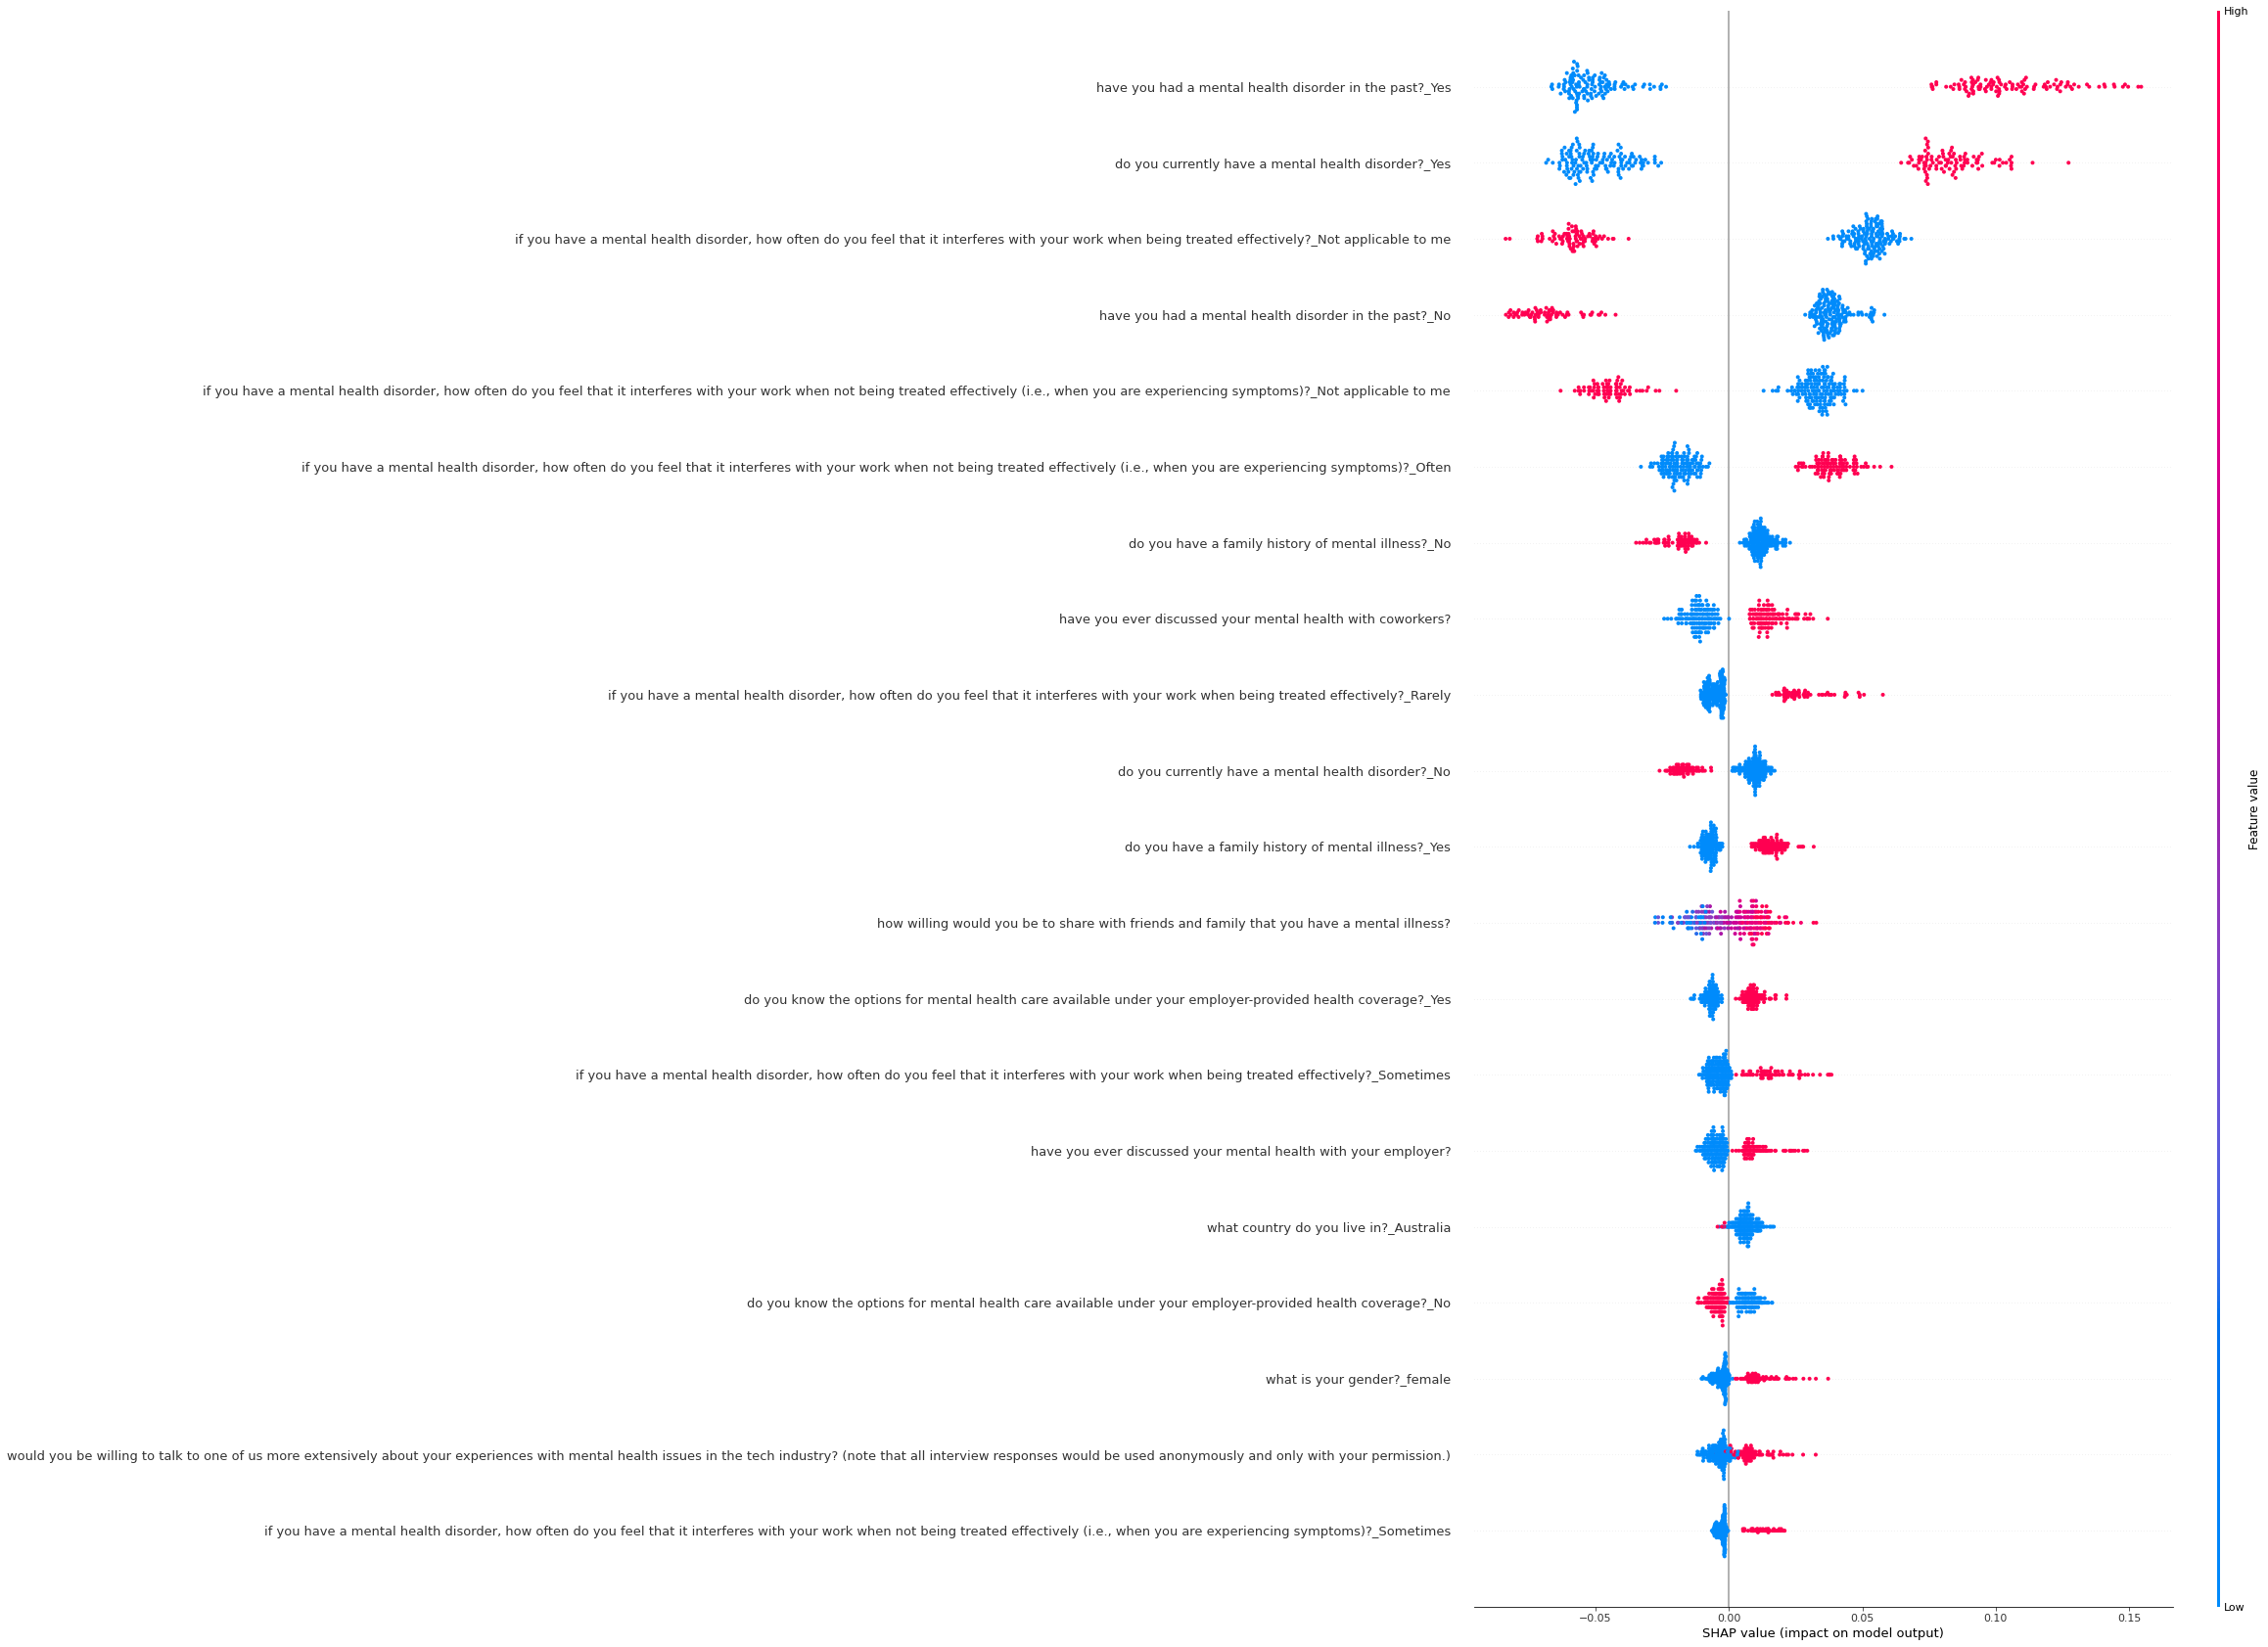

In [292]:
shap.summary_plot(shap_values[1], X_test, X_test.columns, title="SHAP summary plot", plot_size=(16.0, 30.0))

To confirm the results from the models own feature importances, shap values are calculated. The history of mental health disorder and the present mental health state are the most important feature for determining the need of help from a qualified professional. Also, people who thinks that mental health issues are affecting their work as well as those people who believes that mental health issue will affect their work need consultation as well. Having a family history also increase the chance of necessity of help.